# Identication of putative contaminant taxa

In [1]:
setwd("/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome")
require(foreach)
require(tidyverse)
require(ggplot2)
require(data.table)
require(compositions)
require(doParallel)
require(VennDiagram)
registerDoParallel(cores=9)

Loading required package: foreach

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::when()       masks foreach::when()

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: compos

### Data pre-processing functions

In [2]:
load_data <- function(file_path) {
    dat <- as.data.frame(fread(file_path)) %>%
        separate(sample, into = c(NA, "npm_research_id"), sep = "\\.")
    return(dat)
}


load_metadata <- function(file_path, dat) {
    meta <- fread(file_path, na.strings=c("", NA))
    meta <- meta %>% 
        filter(npm_research_id %in% dat$npm_research_id) %>%
        select(-removal_requested_by_supplier) %>%
        replace(is.na(.), "unknown")
    return(meta)
}


subset_metadata <- function(meta, n_subset) {
    meta <- as.data.frame(meta)
    cohorts <- unique(meta$site_supplying_sample)
    subset_vec <- c()

    for (i in cohorts) {
        ids <- meta$npm_research_id[meta$site_supplying_sample == i]
        
        if (length(ids) > n_subset) {
            subset_ids <- sample(ids, n_subset)
            subset_vec <- c(subset_vec, subset_ids)
        } else {
            subset_vec <- c(subset_vec, ids)
        }
    }

    meta_sub <- meta %>%
      filter(npm_research_id %in% subset_vec) 
    return(meta_sub)
}


retrieve_rows_from_meta <- function(dat, meta) {
    return(dat %>% filter(npm_research_id %in% meta$npm_research_id)) 
}


remove_cols <- function(dat, col_to_exclude) {
    return(dat %>% select(-all_of(col_to_exclude)))
}


remove_low_prev_taxa <- function(dat, frac_presence, read_threshold) {
    n_original <- ncol(dat[, colnames(dat) != "npm_research_id"])
    PA_df <- apply(dat[, 2:ncol(dat)], 2, function(x) {ifelse(x > read_threshold, T, F)})
    frac_df <- apply(PA_df, 2, function(x) {sum(x) / nrow(PA_df)})
    to_keep <- names(frac_df[frac_df > frac_presence])
    to_keep <- c("npm_research_id", to_keep)
    n_new <- length(to_keep) - 1
    print(str_glue("{n_new} / {n_original} taxa are present in {frac_presence} of samples"))
    return(dat %>% select(all_of(to_keep)))
}


otu_to_RA <- function(dat) {
    mat <- as.matrix(dat[, colnames(dat) != "npm_research_id"])
    RA_df <- as.data.frame(mat / rowSums(mat))
    RA_df <- add_column(RA_df, dat$npm_research_id, .before = 1)
    colnames(RA_df)[1] <- "npm_research_id"
    
    return(RA_df)
}


RA_to_clr <- function(dat) {
    mat <- dat[, colnames(dat) != "npm_research_id"]
    clr_df <- clr(mat)
    return(cbind(data.frame(npm_research_id = dat$npm_research_id), as.data.frame(clr_df, check.names = F)))
}


get_metadata_plots <- function(meta, meta_cols) {
    meta <- as.matrix(meta)
    meta <- as_tibble(meta, rownames = "sample")

    plots <- list()
    
    for (column in meta_cols) {
        plt <- meta %>%
            mutate(across(everything(), as.character)) %>%
            select(all_of(column)) %>%
            group_by_at(column) %>%
            summarise(n = n()) %>%
            ggplot(aes_string(x = column, y = "n", fill = column)) +
                geom_bar(stat = "identity") +
                theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
                geom_text(aes_string(label = "n"))
        plots[[column]] <- plt
    }
    
    return(plots)
}


get_meta_cols <- function(meta) {
    meta_cols <- colnames(meta)[grep("kit|flow_cell|instrument_id|site_supplying", colnames(meta))]
    to_exclude <- c("library_prep_kit", "hiseq_xtm_flow_cell_v2_5_id")
    meta_cols <- meta_cols[!(meta_cols %in% to_exclude)]
    return(meta_cols)
}


print_group_freqs <- function(meta, meta_cols) {
    for (col in meta_cols) {
        tmp <- tibble(data.frame(meta)) %>%
            group_by(get(col)) %>%
            summarise(n = n())
        print(col)
        print(tmp)
    }
}


get_batch_prevalence <- function(x) {sum(x) / length(x)}


remove_low_sample_levels <- function(dat, metadat, column, min_samples) {
    # Remove levels with < x samples
    tmp <- tibble(data.frame(metadat)) %>%
            group_by(get(column)) %>%
            summarise(n = n())

    # Vector of group levels to keep
    to_keep <- tmp[tmp$n >= min_samples, "get(column)"]$`get(column)`
    to_keep <- to_keep[to_keep != "Unknown"]
    n_levels <- length(to_keep)

    if (n_levels < 2) {
        print(str_glue("After pruning, {column} has < 2 levels"))
    } else {
        print(str_glue("After pruning, {column} has {n_levels} levels"))
    }

    # Remove rows in metadata
    metadat_filt <- metadat %>% filter(get(column) %in% to_keep)

    # Retrieve rows
    dat_filt <- retrieve_rows_from_meta(dat, metadat_filt)
    metadat_filt <- metadat_filt %>% filter(npm_research_id %in% dat_filt$npm_research_id)

    return(list(dat_filt = dat_filt, metadat_filt = metadat_filt))
}


remove_empty_rows <- function(dat) {
    mat <- as.matrix(dat[, colnames(dat) != "npm_research_id"])
    row_sums <- rowSums(mat)
    df_filt <- dat[row_sums != 0, ]
    nrow(df_filt)

    n_original <- nrow(dat)
    n_removed <- n_original - nrow(df_filt)
    
    print(str_glue("{n_removed}/{n_original} samples removed due to having no reads of interest"))
    
    return(df_filt)
}

#### Params

In [3]:
human <- "Homo sapiens"
rank <- "S"
max_prev_t <- 0.25
fold_diff_t <- 2

#### Load and parse data

In [4]:
to_retain <- fread("data/samples_above_100_microbial_reads.txt")$npm_research_id

prev_df <- fread("results/decontamination/prevalence_RA0.005_read10.csv")

species_df <- load_data(str_glue("data/taxonomic_profiles/07_abundance_matrix/abundance_matrix.S.pipeline2_210322.tsv")) %>% 
    filter(npm_research_id %in% to_retain) %>%
    select(all_of(colnames(prev_df)))

all(colnames(species_df) == colnames(prev_df))

# Get non-contaminants/contaminants from diff prev. filter
nc <- read.csv(str_glue("results/decontamination/diff_prev_V3/noncontaminants.RA0.005.read_threshold10.max_prev{max_prev_t}.fold_diff{fold_diff_t}.txt"))$taxa
contams <- read.csv(str_glue("results/decontamination/diff_prev_V3/contaminants.RA0.005.read_threshold10.max_prev{max_prev_t}.fold_diff{fold_diff_t}.txt"))$taxa

# # Set absent species to zero
# species_zeroed <- species_df %>% 
#     select(all_of(colnames(prev_df))) %>%
#     column_to_rownames("npm_research_id")

# prev_bool_df <- prev_df %>%
#     column_to_rownames("npm_research_id")

# for(i in seq(ncol(species_zeroed))) {
#     species_zeroed[!prev_bool_df[, i], i] <- 0
# }

# species_zeroed <- species_zeroed %>% rownames_to_column("npm_research_id")

# Convert to CLR abundances
df_filt <- RA_to_clr(otu_to_RA(species_df))
head(df_filt)

[1] TRUE

,npm_research_id,Sphingobium sp. YG1,Sphingobium sp. RAC03,Sphingobium sp. TKS,Sphingobium sp. Cam5-1,Sphingobium sp. KCTC 72723,Sphingobium sp. PAMC28499,Sphingobium sp. MI1205,Sphingobium sp. SYK-6,Sphingobium sp. CAP-1,⋯,Rickettsia endosymbiont of Ixodes pacificus,Woolly monkey hepatitis B virus,Human betaherpesvirus 5,Human alphaherpesvirus 2,Streptococcus sp. FDAARGOS_522,Torque teno virus 2,Bacillus sp. TK-2,Rickettsia massiliae,Lactobacillus phage Lv-1,Capuchin monkey hepatitis B virus
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,WHB8690,5.9202474,1.8655681,1.5554132,1.172421,1.029320,0.6615953,0.5438123,0.5438123,0.5438123,⋯,0,0,0,0,0,0,0,0,0,0
2,WHB10005,-0.3825544,-1.0757016,-0.3825544,-1.075702,-1.075702,0.0000000,-1.0757016,-1.0757016,0.0229107,⋯,0,0,0,0,0,0,0,0,0,0
3,WHB4505,0.0000000,0.0000000,0.0000000,0.000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,⋯,0,0,0,0,0,0,0,0,0,0
4,WHB7030,-1.0041589,0.0000000,0.0000000,0.000000,0.000000,0.0000000,-1.0041589,0.0000000,0.0000000,⋯,0,0,0,0,0,0,0,0,0,0
5,WHB8628,6.3117017,2.1368872,2.0191041,1.849205,1.885573,1.2614184,1.5491005,1.3259570,1.3259570,⋯,0,0,0,0,0,0,0,0,0,0
6,WHB4900,-0.2055969,-0.2055969,0.3540189,-1.591891,-1.591891,-1.5918913,-1.5918913,-1.5918913,-0.4932790,⋯,0,0,0,0,0,0,0,0,0,0


### Correlation filter after Diff. Prev. + Diff. Abn.

In [5]:
corr_decontam <- function(dat, non_contaminants, contaminants) {
    nc_list <- foreach (non_contaminant_taxon = non_contaminants) %dopar% {
        morsel <- tibble()
        
        for (contaminant_taxon in contaminants) {
            spearman_test <- cor.test(dat[ , contaminant_taxon], dat[, non_contaminant_taxon])
            rho <- spearman_test$estimate
            print(str_glue("{non_contaminant_taxon} has correlation of {rho} with {contaminant_taxon}"))
            morsel <- morsel %>% bind_rows(tibble(non_contaminant_taxon = non_contaminant_taxon, 
                                           contaminant_taxon = contaminant_taxon,
                                           rho = rho))
        }

        return(morsel)
    }

    corr_df <- bind_rows(nc_list)  
    return(corr_df)
}


parse_corr_results <- function(corr_df, nc, corr_t) {
    parsed <- corr_res %>%
    mutate(above_corr = ifelse(rho > corr_t, T, F)) %>%
    group_by(non_contaminant_taxon) %>%
    summarise(n_corr = sum(above_corr))
    
    contaminants <- parsed %>%
        filter(n_corr > 0) %>%
        distinct(non_contaminant_taxon) %>%
        rename(contaminants = non_contaminant_taxon)
    
    non_contaminants <- parsed %>%
        filter(n_corr == 0) %>%
        distinct(non_contaminant_taxon)
    
    return(list(non_contaminants = non_contaminants, contaminants = contaminants))
}

In [6]:
corr_res <- corr_decontam(df_filt, nc, contams)

### Choosing  correlation threshold

#### Case studies

In [7]:
corr_df <- corr_res %>%
    filter(!is.na(rho)) %>%
    mutate(fill_color = case_when(rho <= 0 ~ "<0",
                     rho > 0 & rho <= 0.1 ~ "0-0.1",
                     rho > 0.1 & rho <= 0.2 ~ "0.1-0.2",
                     rho > 0.2 & rho <= 0.3 ~ "0.2-0.3",
                     rho > 0.3 & rho <= 0.5 ~  "0.3-0.5",
                     rho > 0.5 & rho <= 0.7 ~ "0.5-0.7",
                     rho > 0.7 ~ ">0.7")) %>%
    mutate(fill_color = factor(fill_color, levels = c("<0", "0-0.1", "0.1-0.2", "0.2-0.3", "0.3-0.5", "0.5-0.7", ">0.7")))

In [8]:
# taxon <- "Lactobacillus paragasseri"
# taxon_name <- gsub(" ", "_", taxon)

# corr_df %>% 
# filter(non_contaminant_taxon == taxon) %>%
#     ggplot(aes(x = rho, fill = fill_color)) +
#     geom_histogram(bins = 50) +
#     labs(x = "Spearman's rho (CLR)", "No. of contaminants", title = taxon) +
#     scale_fill_manual(values = c("#6699cc", "#ffffcc", "#f39b7fb2", "#e64b35b2", "#d11141"))

# ggsave(str_glue("results/decontamination/correlation_decontamination/{taxon_name}.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.png"))

In [9]:
# taxon <- "Moraxella osloensis"
# taxon_name <- gsub(" ", "_", taxon)
# corr_df %>% 
# filter(non_contaminant_taxon == taxon) %>%
#     ggplot(aes(x = rho, fill = fill_color)) +
#     geom_histogram(bins = 50) +
#     labs(x = "Spearman's rho (CLR)", "No. of contaminants", title = taxon) +
#     scale_fill_manual(values = c("#6699cc", "#ffffcc", "#f39b7fb2", "#e64b35b2", "#d11141"))

# # ggsave(str_glue("results/decontamination/correlation_decontamination/{taxon_name}.png"))

In [10]:
# corr_t <- 0.1
# parsed <- corr_df %>%
#     group_by(non_contaminant_taxon) %>%
#     mutate(above_corr = ifelse(rho > corr_t, T, F)) %>%
#     summarise(diff = sum(above_corr) / n_distinct(corr_df$contaminant_taxon))

# parsed %>%
#  ggplot(aes(x = diff)) +
#     geom_histogram(bins = 50) +
#     labs(x = str_glue("Prop. of NC-C correlations (rho > {corr_t})"), y = "No. of non-contaminants")

# # ggsave(str_glue("results/decontamination/correlation_decontamination/rho_histogram.min_samples{min_samples}.l{lq_p * 100}h{hq_p * 100}.png"))

#### Heatmap of correlations

In [11]:
plot_heatmap <- function(corr_df) {
    wide_df <- corr_df %>%
        pivot_wider(!fill_color, names_from = non_contaminant_taxon, values_from = rho) %>%
        column_to_rownames("contaminant_taxon")

    data <- scale(t(wide_df))
    ord_row <- hclust(dist(data, method = "euclidean"), method = "ward.D")$order

    data <- scale(wide_df)
    ord_col <- hclust(dist(data, method = "euclidean"), method = "ward.D")$order

    hm <- corr_df %>%
        mutate(non_contaminant_taxon = factor(non_contaminant_taxon, levels = colnames(wide_df)[ord_row]), 
               contaminant_taxon = factor(contaminant_taxon, levels = rownames(wide_df)[ord_col])) %>%
        ggplot(aes(x = non_contaminant_taxon, y = contaminant_taxon, fill = fill_color)) +
        geom_tile() +
        theme(axis.ticks.x = element_blank(),
              axis.text.x = element_blank(),
              axis.ticks.y = element_blank(),
              axis.text.y = element_blank(),
              text = element_text(size = 15)) +
        scale_fill_manual(values = c("#6699cc", "#ffffcc", "#f39b7fb2", "#e64b35b2", "#d11141", "darkred", "black")) +
        labs(x = "Non-contaminant species", y = "Contaminant species", fill = "Rho")

    return(hm)
}


#### Before correlation filter

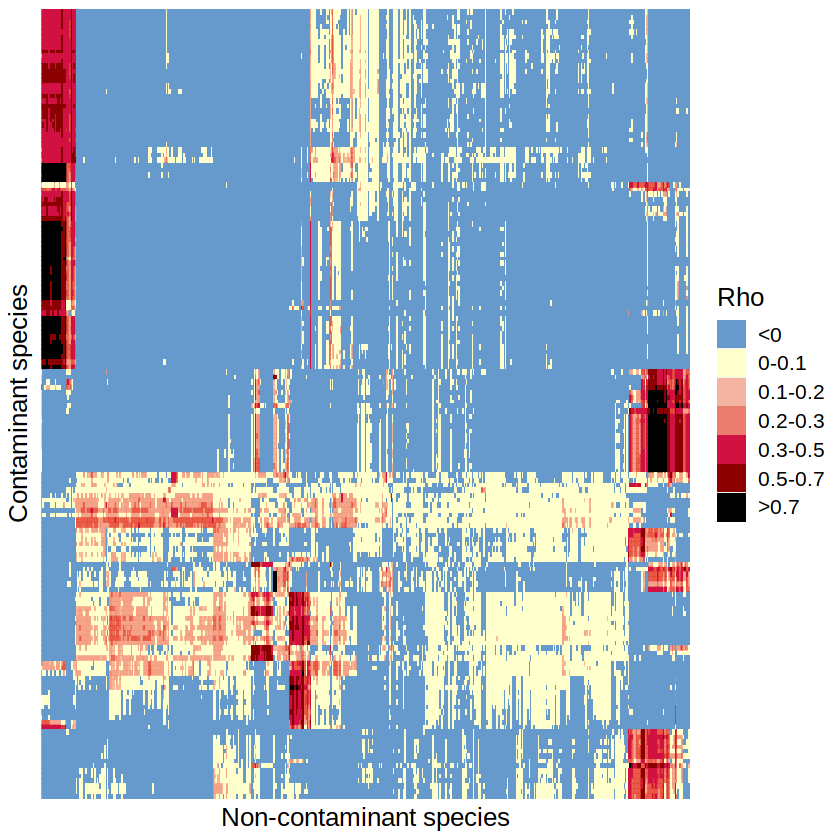

In [12]:
plot_heatmap(corr_df)
ggsave(str_glue("results/decontamination/correlation_decontamination/correlation_heatmap.diff_prev_V3.max_prev{max_prev_t}.fold_diff{fold_diff_t}.png"), 
       dpi = 300, 
       height = 6.67, width = 7.5)

In [13]:
corr_t <- 0.7
corr_parsed <- parse_corr_results(corr_res, nc, corr_t = corr_t)
corr_nc <- corr_parsed[["non_contaminants"]]
corr_c <- corr_parsed[["contaminants"]]

fwrite(corr_nc, 
       str_glue("results/decontamination/correlation_decontamination/nc.diff_prev_V3.RA0.005.read_threshold10.max_prev{max_prev_t}.fold_diff{fold_diff_t}.corr_t{corr_t}.S.n9999.txt"))
fwrite(corr_c, 
       str_glue("results/decontamination/correlation_decontamination/contam.diff_prev_V3.RA0.005.read_threshold10.max_prev{max_prev_t}.fold_diff{fold_diff_t}.corr_t{corr_t}.S.n9999.txt"))

print(length(corr_nc$non_contaminant_taxon))
print(length(corr_c$contaminants))

[1] 645
[1] 65


#### After removal

Saving 6.67 x 6.67 in image



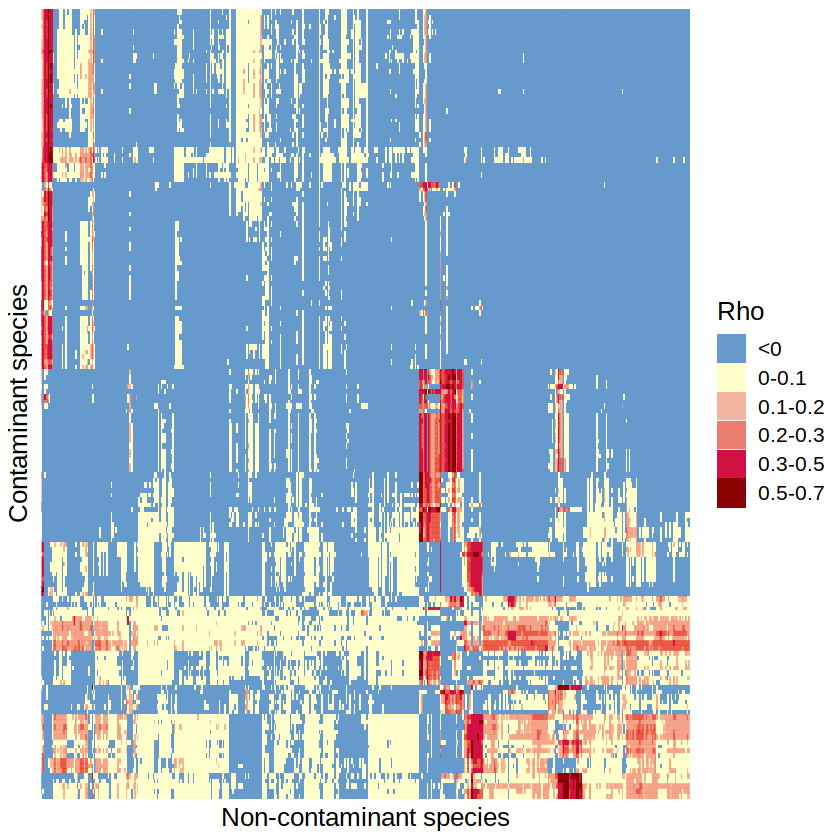

In [14]:
plot_heatmap(corr_df %>% filter(non_contaminant_taxon %in% corr_nc$non_contaminant_taxon))
ggsave(str_glue("results/decontamination/correlation_decontamination/correlation_heatmap.after_corr.diff_prev_V3.max_prev{max_prev_t}.fold_diff{fold_diff_t}.corr_t{corr_t}.png"), dpi = 300)

## Correlation within contaminant

In [15]:
contam_df <- df_filt %>% select(all_of(corr_c$contaminants))
corr_within <- cor(contam_df, method = c("spearman")) %>% as_tibble()
corr_within

Achromobacter insolitus,Achromobacter pestifer,Achromobacter sp. B7,Achromobacter sp. MFA1 R4,Allosphingosinicella indica,Bosea sp. ANAM02,Bosea sp. AS-1,Bosea sp. F3-2,Brevundimonas sp. 'scallop',Brevundimonas vesicularis,⋯,Sphingopyxis fribergensis,Sphingopyxis granuli,Sphingopyxis lindanitolerans,Sphingopyxis macrogoltabida,Sphingopyxis sp. 113P3,Sphingopyxis sp. FD7,Sphingopyxis sp. PAMC25046,Sphingopyxis sp. QXT-31,Sphingosinicella sp. BN140058,Stenotrophomonas sp. LM091
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.000000000,0.49887931,0.484657765,0.4757201888,-0.19521754,-0.18057295,-0.24161730,-0.11729382,-0.05363226,-0.02353219,⋯,-0.18020531,-0.18710986,-0.17300767,-0.261624810,-0.217701830,-0.24352203,-0.22037854,-0.20536611,-0.214384381,0.10690082
0.498879309,1.00000000,0.520109721,0.4964527960,-0.28045258,-0.13902499,-0.21563332,-0.02637479,-0.15162278,-0.11882622,⋯,-0.24649415,-0.25478364,-0.28412316,-0.338899276,-0.285848490,-0.28540775,-0.31926687,-0.27910744,-0.345447018,0.23910290
0.484657765,0.52010972,1.000000000,0.4672446136,-0.22043543,-0.13546404,-0.21867789,-0.05343521,-0.11168181,-0.06556444,⋯,-0.19910758,-0.21108452,-0.21225878,-0.298017121,-0.234038570,-0.24218730,-0.24790594,-0.21536199,-0.259252921,0.16009364
0.475720189,0.49645280,0.467244614,1.0000000000,-0.19629630,-0.17879577,-0.21213378,-0.05899728,-0.14046983,-0.09923757,⋯,-0.15225993,-0.20493641,-0.19769013,-0.259304606,-0.206800001,-0.22232105,-0.22139004,-0.19539836,-0.246675043,0.16456365
-0.195217539,-0.28045258,-0.220435426,-0.1962962985,1.00000000,-0.13999605,0.12976937,-0.12573975,-0.01798719,-0.04073606,⋯,0.60745701,0.60837329,0.62737984,0.457578148,0.640049755,0.55925616,0.62890153,0.62762386,0.595519114,-0.36733134
-0.180572951,-0.13902499,-0.135464045,-0.1787957740,-0.13999605,1.00000000,0.47224045,0.50626549,-0.03060108,-0.02203275,⋯,-0.15921919,-0.19543417,-0.15112622,0.211470751,-0.108132517,-0.16796845,-0.07553819,-0.10612885,-0.004203057,0.19649990
-0.241617300,-0.21563332,-0.218677890,-0.2121337785,0.12976937,0.47224045,1.00000000,0.46517946,-0.15731818,-0.21017223,⋯,0.12164633,0.13003455,0.09997487,0.436901132,0.169175918,0.12924292,0.19323317,0.15330504,0.204192524,0.17321627
-0.117293816,-0.02637479,-0.053435212,-0.0589972830,-0.12573975,0.50626549,0.46517946,1.00000000,-0.27631201,-0.24254570,⋯,-0.12222848,-0.20941956,-0.17867819,0.174429704,-0.086791256,-0.13600797,-0.07573009,-0.10583625,-0.051900403,0.32486608
-0.053632258,-0.15162278,-0.111681810,-0.1404698309,-0.01798719,-0.03060108,-0.15731818,-0.27631201,1.00000000,0.70798518,⋯,-0.04313655,0.04690581,0.06114729,-0.070160783,-0.056340062,-0.02928671,-0.04859579,-0.01978425,0.065374418,-0.29932052


In [16]:
contam_df <- df_filt %>% select(all_of(corr_c$contaminants))
corr_within_contam <- cor(contam_df, method = c("spearman")) %>% as_tibble()

nc_df <- df_filt %>% select(all_of(corr_nc$non_contaminant_taxon))
corr_within_nc <- cor(nc_df, method = c("spearman")) %>% as_tibble()

plot_heatmap_within(corr_within_nc, str_glue("Non-contaminants (n = {nrow(corr_nc)})"))
plot_heatmap_within(corr_within_contam, str_glue("Contaminants (n = {nrow(corr_c)})"))

ERROR: Error in plot_heatmap_within(corr_within_nc, str_glue("Non-contaminants (n = {nrow(corr_nc)})")): could not find function "plot_heatmap_within"


In [ ]:
plot_heatmap_within <- function(corr_within, title) {
    long_df <- corr_within %>%
        add_column(taxa = colnames(corr_within)) %>%
        pivot_longer(!taxa, names_to = "taxa2", values_to = "rho") %>%
        mutate(fill_color = case_when(rho <= 0 ~ "<0",
                         rho > 0 & rho <= 0.1 ~ "0-0.1",
                         rho > 0.1 & rho <= 0.2 ~ "0.1-0.2",
                         rho > 0.2 & rho <= 0.3 ~ "0.2-0.3",
                         rho > 0.3 & rho <= 0.5 ~  "0.3-0.5",
                         rho > 0.5 & rho <= 0.7 ~ "0.5-0.7",
                         rho > 0.7 ~ ">0.7")) %>%
        mutate(fill_color = factor(fill_color, levels = c("<0", "0-0.1", "0.1-0.2", "0.2-0.3", "0.3-0.5", "0.5-0.7", ">0.7")))

    data <- scale(t(corr_within))
    ord_row <- hclust(dist(data, method = "euclidean"), method = "ward.D")$order

    hm <- long_df %>%
        mutate(taxa = factor(taxa, levels = colnames(corr_within)[ord_row]), 
               taxa2 = factor(taxa2, levels = colnames(corr_within)[ord_row])) %>%
        ggplot(aes(x = taxa, y = taxa2, fill = fill_color)) +
        geom_tile() +
        theme(axis.ticks.x = element_blank(),
              axis.text.x = element_blank(),
              axis.ticks.y = element_blank(),
              axis.text.y = element_blank(),
              text = element_text(size = 15)) +
        scale_fill_manual(values = c("#6699cc", "#ffffcc", "#f39b7fb2", "#e64b35b2", "#d11141", "darkred", "black")) +
        labs(x = title, y = title, fill = "Rho")

    return(hm)
}


### Controls

In [ ]:
dawdwadw

In [ ]:
# pos_control <- read.csv("data/reported_controls/damgaard_2015_positive.txt")$positive_controls
# torque_tenos <- colnames(df_filt)[grepl("torque teno", colnames(df_filt), ignore.case = T)]
# herpes <- colnames(df_filt)[grepl("herpes", colnames(df_filt), ignore.case = T)]
# pos_control <- c(pos_control, 
#                  "Escherichia coli",
#                  "Pasteurella multocida", 
#                  "Bartonella henselae", "Bartonella clarridgeiae", 
#                  "Enterococcus faecalis", "Cutibacterium acnes", "Staphylococcus epidermis", "Actinomyces viscosus",
#                  "Streptococcus agalactiae",
#                  "Yersinia enterocolitica",
#                  "Leclercia adecarboxylata",
#                  "Streptococcus pneumoniae",
#                  torque_tenos,
#                  herpes
#                  )
# neg_control1 <- read.csv("data/reported_controls/asmp_parsed_negative.txt")$taxa
# neg_control2 <- read.csv("data/reported_controls/chng_2020_parsed_negative.txt")$taxa
# neg_control3 <- read.csv("data/reported_controls/caregiver_parsed_negative.txt")$taxa

# intersection <- Reduce(intersect, list(neg_control1, neg_control2, neg_control3))
# union <- unique(c(neg_control1, neg_control2, neg_control3))

# # At least 2 studies
# all_neg <- table(c(neg_control1, neg_control2, neg_control3))
# semi_union <- names(all_neg[all_neg >= 2])

# pos_not_intersect <- pos_control[!(pos_control %in% intersection)]
# pos_not_union <- pos_control[!(pos_control %in% union)]
# pos_not_semi <- pos_control[!(pos_control %in% semi_union)]

# print(length(intersection))
# print(length(union))
# print(length(semi_union))
# print(length(pos_control))
# print(length(pos_not_intersect))
# print(length(pos_not_union))

In [ ]:

# venn_list1 <- list(nc = corr_nc$non_contaminant_taxon,
#                   contam = corr_c$contaminants, 
#                   pos_not_semi = pos_not_semi)

# venn_list2 <- list(nc = corr_nc$non_contaminant_taxon,
#                   contam = corr_c$contaminants, 
#                   semi_union = semi_union)

# # venn.diagram(venn_list1, 
# #              filename = str_glue("results/decontamination/correlation_decontamination/corr_decontamination_results_pos_controls.png"),
# # #              category.names = c("Identified non-contaminants", "Identified contaminants", "Found in blood"),
# #              category.names = c("", "", ""),
# #              print.mode = c("raw"),
# #              fill = c("#999999", "#E69F00", "#66a182")
# #              )

# # venn.diagram(venn_list2, 
# #              filename = str_glue("results/decontamination/correlation_decontamination/corr_decontamination_results_neg_controls.png"),
# # #              category.names = c("Identified non-contaminants", "Identified contaminants", "Common contaminants (union)"),
# #              category.names = c("", "", ""),
# #              print.mode = c("raw"),
# #              fill = c("#999999", "#E69F00", "#f8766d")
# #              )

# # filename = str_glue("results/decontamination/diff_prev_V3/decontamination_results_pos_controls.png"),

In [ ]:
# corr_nc$non_contaminant_taxon[corr_nc$non_contaminant_taxon %in% pos_control]

In [ ]:
# tibble(stage = c("Raw", "Non-zero filter", "Diff. prevalence", "Corr. filter"),
#        n_species = c(ncol(df) - 3, ncol(df_filt) - 1, length(nc), length(corr_nc$non_contaminant_taxon))) %>%
#     mutate(stage = factor(stage, levels = c("Raw", "Non-zero filter", "Diff. prevalence", "Corr. filter"))) %>%
#     ggplot(aes(x = 1, y = n_species, fill = stage)) +
#         theme_bw() +
#         geom_bar(stat = "identity", position = "identity", alpha = 0.4) +
#     scale_fill_manual(values = c("grey", "#edae49", "#d1495b", "#66a182")) +
#     theme(panel.grid = element_blank()) +
#     labs(y = "No. of species left")